<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/tmax.tmin.tmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Don

<ipython-input-9-0c22321fb1f1>:11: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
<ipython-input-9-0c22321fb1f1>:11: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)


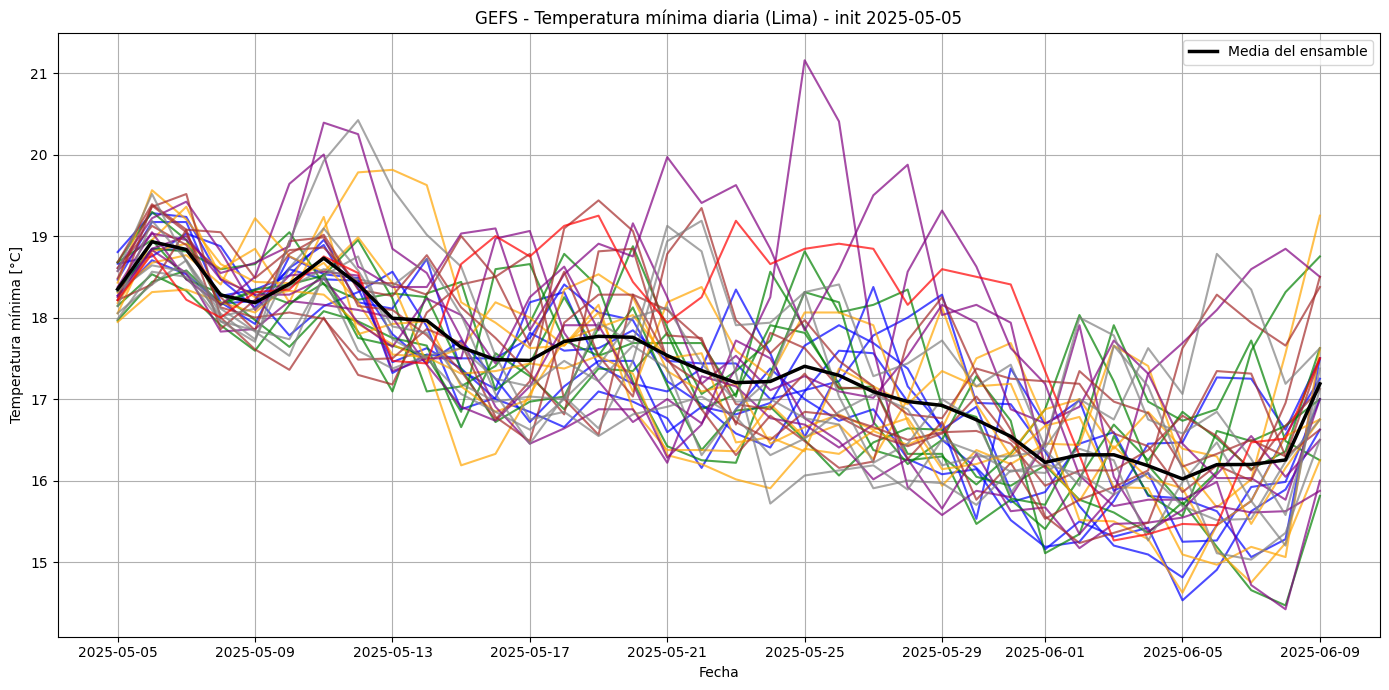

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#COLOCAR COORDENADA PARA LIMA
lat_lima = -12.0
lon_lima = -77.0

#COLOCAR FECHAS YYYY-MM-DDT00
init_time = "2025-06-03T00"

# Abrir dataset completo y seleccionar solo la variable necesaria
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
ds_var = ds["minimum_temperature_2m"].sel(init_time=init_time, latitude=lat_lima, longitude=lon_lima, method="nearest")

# Crear coordenada de tiempo completo
forecast_time = ds_var.init_time + ds_var.lead_time
ds_var = ds_var.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# Agrupar por día (media diaria por miembro)
ds_daily = ds_var.groupby("forecast_time.date").mean()

# Crear colores para grupos de 5 miembros
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'gray', 'red']
member_colors = [colors[i // 5] for i in range(ds_daily.ensemble_member.size)]

# Iniciar figura
plt.figure(figsize=(14, 7))
for i, member in enumerate(ds_daily.ensemble_member.values):
    plt.plot(ds_daily.date, ds_daily.sel(ensemble_member=member), color=member_colors[i], alpha=0.7)

# Línea del promedio del ensamble
ensemble_mean = ds_daily.mean(dim="ensemble_member")
plt.plot(ds_daily.date, ensemble_mean, color="black", linewidth=2.5, label="Media del ensamble")

# Personalización del gráfico
plt.title("GEFS - Temperatura mínima diaria (Lima) - init 2025-05-05")
plt.xlabel("Fecha")
plt.ylabel("Temperatura mínima [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-3-91c7c454aebd>:13: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
<ipython-input-3-91c7c454aebd>:13: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)


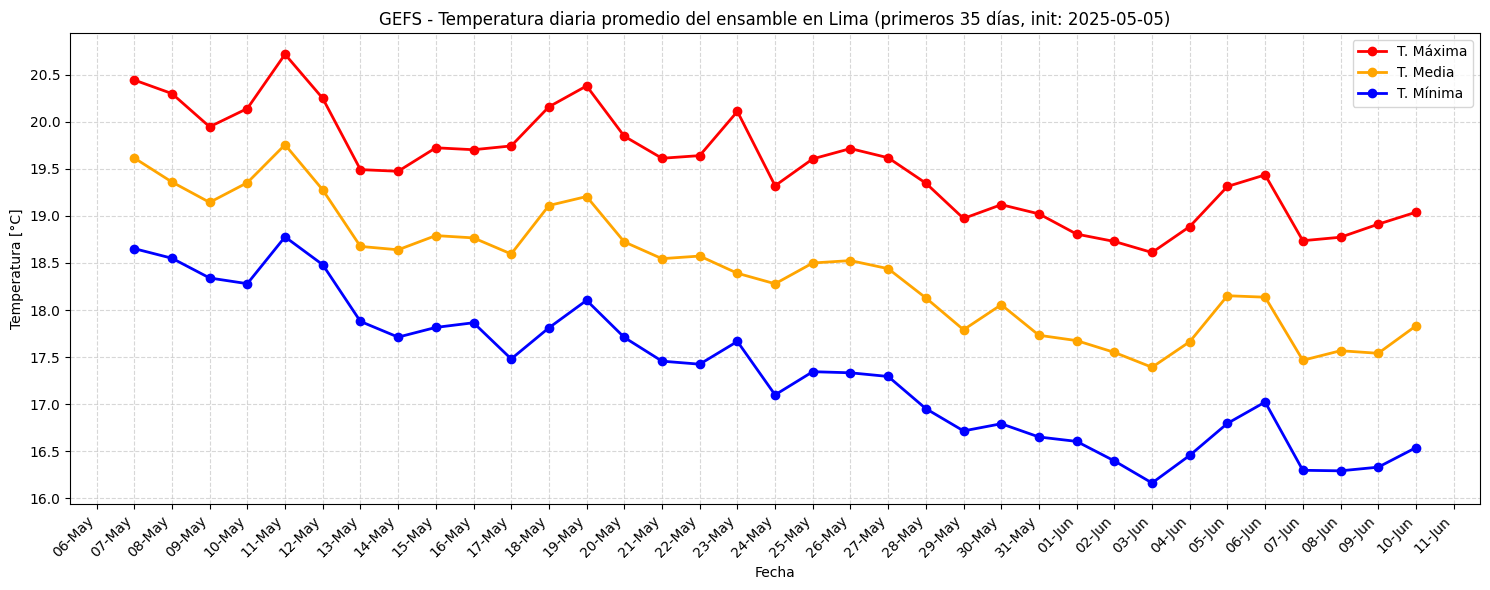

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

#COLOCAR COORDENADA PARA LIMA
lat_lima = -12.0
lon_lima = -77.0

#COLOCAR FECHAS YYYY-MM-DDT00
init_time = "2025-06-03T00"


vars_needed = ["maximum_temperature_2m", "temperature_2m", "minimum_temperature_2m"]

# Abrir y seleccionar
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
ds = ds[vars_needed].sel(init_time=init_time, latitude=lat, longitude=lon, method="nearest")

# Crear forecast_time
forecast_time = ds.init_time + ds.lead_time
ds = ds.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})

# Agrupar por día calendario y calcular promedio del ensamble
ds_daily = ds.groupby("forecast_time.date").mean(dim=["forecast_time", "ensemble_member"])

# Limitar a los primeros 35 días
ds_daily = ds_daily.isel(date=slice(1, 35))
fechas = ds_daily["date"].values

# Graficar
plt.figure(figsize=(15, 6))
plt.plot(fechas, ds_daily["maximum_temperature_2m"], label="T. Máxima", color="red", marker='o', linewidth=2)
plt.plot(fechas, ds_daily["temperature_2m"], label="T. Media", color="orange", marker='o', linewidth=2)
plt.plot(fechas, ds_daily["minimum_temperature_2m"], label="T. Mínima", color="blue", marker='o', linewidth=2)

# Formato de fechas en eje X
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.xticks(rotation=45, ha="right")

# Configurar eje Y con paso de 0.5 °C
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))

# Personalización final
plt.title("GEFS - Temperatura diaria promedio del ensamble en Lima (primeros 35 días, init: 2025-05-05)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura [°C]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
